import /content/drive/MyDrive/v2x_data/veremi_stratified_200000.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)




Mounted at /content/drive


In [2]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time: 2025-06-15 15:41:57


In [3]:
import zipfile
zip_path = '/content/drive/MyDrive/v2x_data/veremi_stratified_200000.zip'
extract_dir = '/content/veremi_subsets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)


Unzipped to: /content/veremi_subsets


In [4]:
import pandas as pd

df_balanced = pd.read_csv('/content/veremi_subsets/veremi_stratified_200000.csv')
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   type          200000 non-null  int64  
 1   sendTime      200000 non-null  float64
 2   sender        200000 non-null  int64  
 3   senderPseudo  200000 non-null  int64  
 4   messageID     200000 non-null  int64  
 5   class         200000 non-null  int64  
 6   posx          200000 non-null  float64
 7   posy          200000 non-null  float64
 8   posz          200000 non-null  float64
 9   spdx          200000 non-null  float64
 10  spdy          200000 non-null  float64
 11  spdz          200000 non-null  float64
 12  aclx          200000 non-null  float64
 13  acly          200000 non-null  float64
 14  aclz          200000 non-null  float64
 15  hedx          200000 non-null  float64
 16  hedy          200000 non-null  float64
 17  hedz          200000 non-null  float64
 18  Atta

In [5]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pandas as pd

# Define subset sizes
subset_sizes = [20000, 40000, 80000, 120000, 160000, 200000]

# Split normal and attack records
df_normal = df_balanced[df_balanced['binary_label'] == 0]
df_attack = df_balanced[df_balanced['binary_label'] == 1]
attack_class_proportions = df_attack['class'].value_counts(normalize=True)

# Initialize tracking DataFrame
subset_class_summary = pd.DataFrame()

for size in subset_sizes:
    n_attack = size // 2
    n_normal = size // 2

    # Stratified attack sampling
    attack_samples = []
    for cls, frac in attack_class_proportions.items():
        cls_pool = df_attack[df_attack['class'] == cls]
        n_cls = min(len(cls_pool), int(n_attack * frac))
        attack_samples.append(cls_pool.sample(n=n_cls, random_state=42))
    attack_subset = pd.concat(attack_samples)

    # Pad with extra if needed
    if len(attack_subset) < n_attack:
        remaining = n_attack - len(attack_subset)
        extra = df_attack.drop(attack_subset.index).sample(n=remaining, random_state=42)
        attack_subset = pd.concat([attack_subset, extra])

    # Normal class sampling
    normal_subset = df_normal.sample(n=n_normal, random_state=42)

    # Combine and shuffle
    df_subset = shuffle(pd.concat([attack_subset, normal_subset]), random_state=42).reset_index(drop=True)

    # Save to file
    df_subset.to_csv(f'veremi_stratified_{size}.csv', index=False)
    print(f"\n Saved veremi_stratified_{size}.csv with {len(df_subset)} records")
    print(df_subset["binary_label"].value_counts())
    # ---- Plot distributions ----
    binary_counts = df_subset['binary_label'].value_counts(normalize=True) * 100
    class_counts = df_subset['class'].value_counts(normalize=True).sort_index() * 100
    # ---- Track class distribution for summary ----
    class_row = class_counts.copy()
    class_row['subset_size'] = size
    subset_class_summary = pd.concat([subset_class_summary, class_row.to_frame().T], ignore_index=True)
    print("------------")

# ---- Final formatting ----
subset_class_summary = subset_class_summary.set_index('subset_size')
subset_class_summary.index.name = 'Sample Size'
subset_class_summary = subset_class_summary[sorted(subset_class_summary.columns, key=lambda x: int(x))]
subset_class_summary = subset_class_summary.fillna(0)
subset_class_summary.head(10)


 Saved veremi_stratified_20000.csv with 20000 records
binary_label
0    10000
1    10000
Name: count, dtype: int64
------------

 Saved veremi_stratified_40000.csv with 40000 records
binary_label
0    20000
1    20000
Name: count, dtype: int64
------------

 Saved veremi_stratified_80000.csv with 80000 records
binary_label
0    40000
1    40000
Name: count, dtype: int64
------------

 Saved veremi_stratified_120000.csv with 120000 records
binary_label
0    60000
1    60000
Name: count, dtype: int64
------------

 Saved veremi_stratified_160000.csv with 160000 records
binary_label
0    80000
1    80000
Name: count, dtype: int64
------------

 Saved veremi_stratified_200000.csv with 200000 records
binary_label
0    100000
1    100000
Name: count, dtype: int64
------------


class,0,9,10,11,12,13,14,15,16,17,18,19
Sample Size,,,,,,,,,,,,
20000.0,50.0,2.2500,2.2750,2.335000,2.2700,6.91500,6.675000,6.805000,9.250000,2.3300,4.5750,4.320000
40000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91500,6.675000,6.810000,9.235000,2.3325,4.5750,4.322500
80000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91625,6.672500,6.807500,9.238750,2.3325,4.5750,4.322500
120000.0,50.0,2.2525,2.2775,2.335000,2.2700,6.91500,6.674167,6.807500,9.236667,2.3325,4.5750,4.324167
160000.0,50.0,2.2525,2.2775,2.335625,2.2700,6.91625,6.673750,6.808125,9.235625,2.3325,4.5750,4.323125
200000.0,50.0,2.2530,2.2780,2.335000,2.2705,6.91500,6.673500,6.807500,9.236000,2.3330,4.5755,4.323000


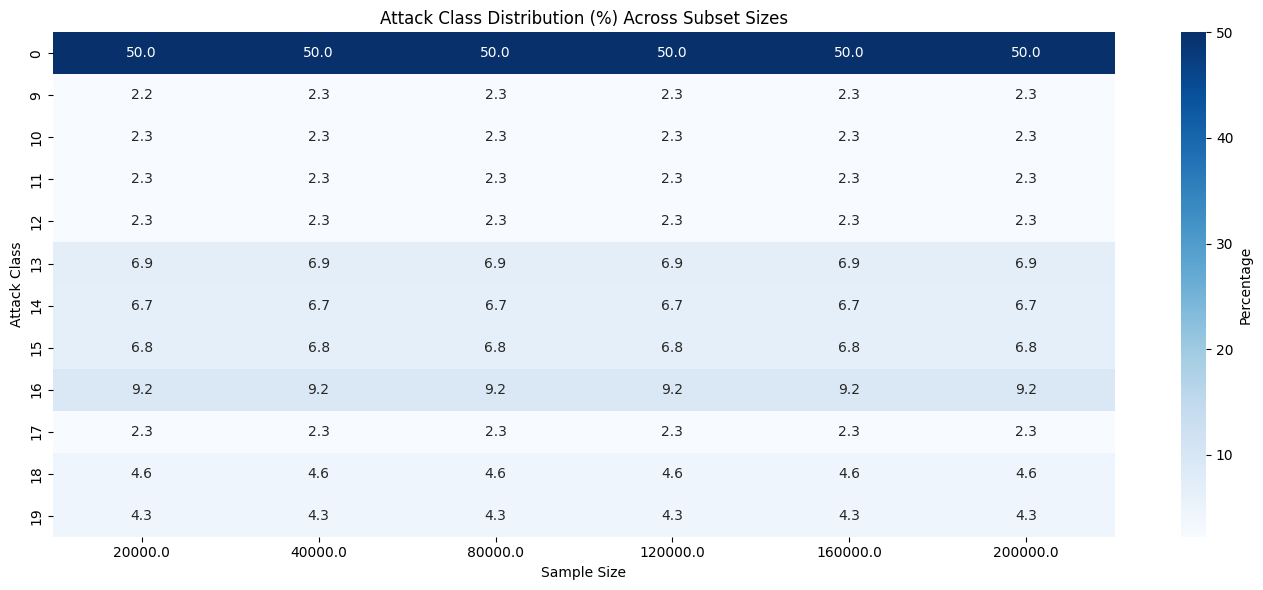

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(subset_class_summary.T, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label': 'Percentage'})

plt.title("Attack Class Distribution (%) Across Subset Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Attack Class")
plt.tight_layout()
plt.show()


In [7]:
import plotly.graph_objects as go
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Melt DataFrame to long format
df_long = subset_class_summary.reset_index().melt(id_vars='Sample Size', var_name='Attack Class', value_name='Percentage')
df_long['Attack Class'] = df_long['Attack Class'].astype(str)

# Generate distinct colors for each class using a colormap
unique_classes = sorted(df_long['Attack Class'].unique(), key=lambda x: int(x))
color_map = cm.get_cmap('tab20', len(unique_classes))
class_colors = {cls: mcolors.to_hex(color_map(i)) for i, cls in enumerate(unique_classes)}

# Create 3D lines for each (Sample Size, Attack Class)
fig = go.Figure()

for _, row in df_long.iterrows():
    x = row['Sample Size']
    y = row['Attack Class']
    z = row['Percentage']
    color = class_colors[y]

    fig.add_trace(go.Scatter3d(
        x=[x, x],
        y=[y, y],
        z=[0, z],
        mode='lines',
        line=dict(color=color, width=10),
        name=f'Class {y}',
        showlegend=False,
        hovertemplate=f"Sample Size: {x}<br>Attack Class: {y}<br>Percentage: {z:.2f}%<extra></extra>"
    ))

# Add legend entries manually (one per class)
for cls, color in class_colors.items():
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='lines',
        line=dict(color=color, width=10),
        name=f'Class {cls}',
        showlegend=True
    ))

# Layout
fig.update_layout(
    title="3D Class-Wise Distribution Across Sample Sizes",
    scene=dict(
        xaxis_title='Sample Size',
        yaxis_title='Attack Class',
        zaxis_title='Percentage',
    ),
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()


<ipython-input-7-981602176>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(unique_classes))


## LSTM TESTING 20000

In [8]:
import pandas as pd

df = pd.read_csv('/content/veremi_stratified_20000.csv')
df.info()
df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   type          20000 non-null  int64  
 1   sendTime      20000 non-null  float64
 2   sender        20000 non-null  int64  
 3   senderPseudo  20000 non-null  int64  
 4   messageID     20000 non-null  int64  
 5   class         20000 non-null  int64  
 6   posx          20000 non-null  float64
 7   posy          20000 non-null  float64
 8   posz          20000 non-null  float64
 9   spdx          20000 non-null  float64
 10  spdy          20000 non-null  float64
 11  spdz          20000 non-null  float64
 12  aclx          20000 non-null  float64
 13  acly          20000 non-null  float64
 14  aclz          20000 non-null  float64
 15  hedx          20000 non-null  float64
 16  hedy          20000 non-null  float64
 17  hedz          20000 non-null  float64
 18  Attack        20000 non-nu

,type,sendTime,sender,senderPseudo,messageID,class,posx,posy,posz,spdx,...,spdz,aclx,acly,aclz,hedx,hedy,hedz,Attack,Attack_type,binary_label
0,4,56645.238071,81621,10816215,244255294,0,249.824980,405.237117,0.0,-6.011002,...,0.0,2.751941,2.062643,0.0,-0.804021,-0.594600,0.0,Normal,Normal behavior,0
1,4,62703.878111,94773,10947736,282677119,13,1180.833832,784.077835,0.0,-9.630062,...,0.0,0.378693,0.408204,0.0,-0.719064,-0.694944,0.0,Attack,DoS disruptive,1
2,4,48553.276086,67671,10676714,202740336,10,920.863634,628.141824,0.0,3.410431,...,0.0,-1.318903,-2.977396,0.0,0.445309,0.895377,0.0,Attack,Data replay,1
3,4,28123.107181,18975,20189752,45141196,16,916.104651,621.375901,0.0,-1.454104,...,0.0,-1.466771,-3.105949,0.0,0.471753,0.881731,0.0,Attack,DoS random sybil,1
4,4,24903.305602,9729,1097292,16869316,0,899.948212,589.091061,0.0,6.965031,...,0.0,-0.369491,-0.558042,0.0,0.671635,0.740882,0.0,Normal,Normal behavior,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4,67645.466708,113763,101137636,358613707,0,273.868611,423.324800,0.0,-9.250936,...,0.0,2.193360,1.751994,0.0,-0.909155,-0.416458,0.0,Normal,Normal behavior,0
19996,4,33963.614750,39897,10398973,125038911,0,161.859199,718.821045,0.0,-1.960121,...,0.0,-0.009112,0.061856,0.0,-0.044394,0.999014,0.0,Normal,Normal behavior,0
19997,4,65171.490107,104073,101040736,319716230,14,657.564877,779.357255,0.0,13.719221,...,0.0,0.847514,1.799761,0.0,-0.670660,-0.728144,0.0,Attack,Data replay sybil,1
19998,4,29324.745671,23535,20235352,61461778,16,1390.291153,1148.072546,0.0,0.301333,...,0.0,0.291288,0.821085,0.0,-0.375159,-0.926960,0.0,Attack,DoS random sybil,1


preprocessing pipeline

* Loads the CSV
* Drops irrelevant columns
* Normalizes with StandardScaler
* Reshapes for LSTM
* Splits into train/test sets
* Returns all ready-to-train arrays

In [9]:
# STEP 1: Install TensorFlow (only once)
!pip install tensorflow


In [10]:
# STEP 2: Imports
import pandas as pd
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense


In [11]:
# STEP 3: Load or Initialize Results DataFrame
try:
    results_df = pd.read_csv("/content/lstm_test_results.csv")
    print("Loaded previous results")
except FileNotFoundError:
    results_df = pd.DataFrame(columns=[
        'Timestamp', 'Model', 'Dataset', 'Sample Size', 'Training Time (s)', 'Best Epoch','Accuracy', 'Precision', 'Recall', 'F1 Score',
        'Confusion Matrix', 'CPU Usage (%)', 'Memory Usage (MB)', 'Model Size (MB)', 'Inference Time (s)'
    ])
    print("Created new results table")



Created new results table


* 90:5:5 train/val/test split
* Validation accuracy tracking
* Early stopping to prevent overfitting
* Train/validation loss/accuracy plots

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def prepare_lstm_dataset(file_path, random_state=42):
    df = pd.read_csv(file_path)
    drop_cols = ['Attack', 'Attack_type', 'class', 'binary_label', 'messageID', 'sender', 'senderPseudo']
    X = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    y = df['binary_label'].values

    # Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 90% train, 5% val, 5% test
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.10, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    return X_train, X_val, X_test, y_train, y_val, y_test, len(df)



In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from datetime import datetime
import matplotlib.pyplot as plt
import os

def train_and_evaluate_lstm(xModel, X_train, X_val, X_test, y_train, y_val, y_test, dataset_name, sample_size, results_df):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_path = f'{sample_size}_mcp_{timestamp}.keras'

    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    # Setup callbacks: EarlyStopping + ModelCheckpoint
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

    # Train model
    train_start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    training_time = time.time() - train_start

    # Load best model
    model = load_model(model_path)

    # Predict and evaluate
    infer_start = time.time()
    y_pred_prob = model.predict(X_test).ravel()
    inference_time = (time.time() - infer_start) / len(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    patience_used = len(history.history['val_loss']) - best_epoch

    cpu_usage = psutil.cpu_percent(interval=1)
    memory_usage = psutil.virtual_memory().used / (1024 ** 2)
    model_size = os.path.getsize(model_path) / (1024 * 1024)

    # Log results
    results_df.loc[len(results_df)] = {
        'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Model': xModel,
        'Dataset': dataset_name,
        'Sample Size': sample_size,
        'Training Time (s)': round(training_time, 2),
        'Best Epoch': best_epoch,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': str(cm),
        'CPU Usage (%)': cpu_usage,
        'Memory Usage (MB)': round(memory_usage, 2),
        'Model Size (MB)': model_size,
        'Inference Time (s)': round(inference_time, 6)
    }

    # Plot loss and accuracy with vertical line at best epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Early stopping triggered. Best epoch: {best_epoch}, patience used: {patience_used}")
    print(f"Best model saved to: {model_path}")

    return results_df



In [15]:
import matplotlib.pyplot as plt

def save_and_visualize_results(results_df, xmarker='o', save_path="lstm_test_results.csv"):
    # Save to CSV
    results_df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")

    # Plot selected metrics as markers only (no connecting lines)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.scatter(results_df['Sample Size'], results_df[metric], marker=xmarker, label=metric)

    plt.xlabel("Sample Size")
    plt.ylabel("Score")
    plt.title("LSTM Classification Metrics by Sample Size")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display last result row
    from IPython.display import display
    display(results_df.tail(1))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5840 - loss: 0.6392
Epoch 1: val_loss improved from inf to 0.58090, saving model to 20000_mcp_2025-06-15_15-42-39.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5842 - loss: 0.6390 - val_accuracy: 0.6700 - val_loss: 0.5809
Epoch 2/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6560 - loss: 0.5786
Epoch 2: val_loss improved from 0.58090 to 0.56848, saving model to 20000_mcp_2025-06-15_15-42-39.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6561 - loss: 0.5786 - val_accuracy: 0.6770 - val_loss: 0.5685
Epoch 3/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6858 - loss: 0.5616
Epoch 3: val_loss improved from 0.56848 to 0.55695, saving model to 20000_mcp_2025-06-15_15-42-39.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6858 - loss: 0.5616 - val_accuracy: 0.6780 - val_loss: 0.5569
Epoch 4/50
277/282 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6930 - loss: 0

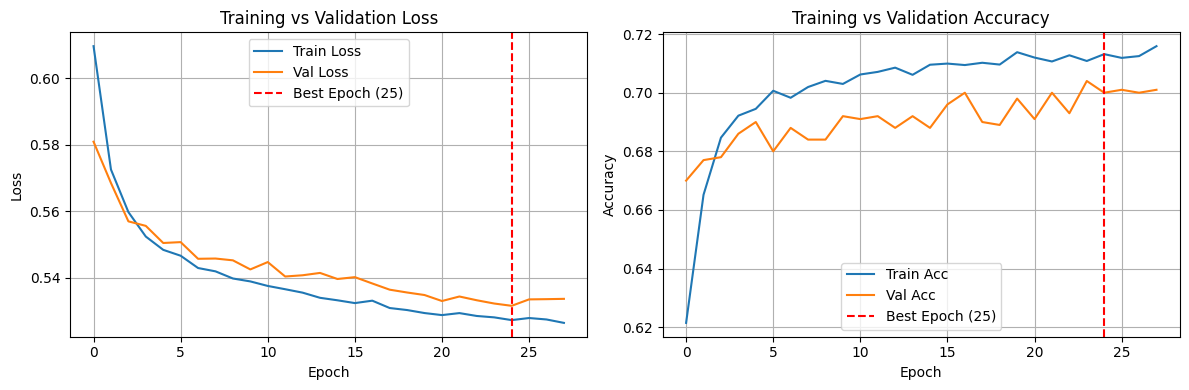

Early stopping triggered. Best epoch: 25, patience used: 3
Best model saved to: 20000_mcp_2025-06-15_15-42-39.keras


In [16]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_20000.csv')
results_df = train_and_evaluate_lstm("LSTM_64_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)


Results saved to lstm_test_results.csv


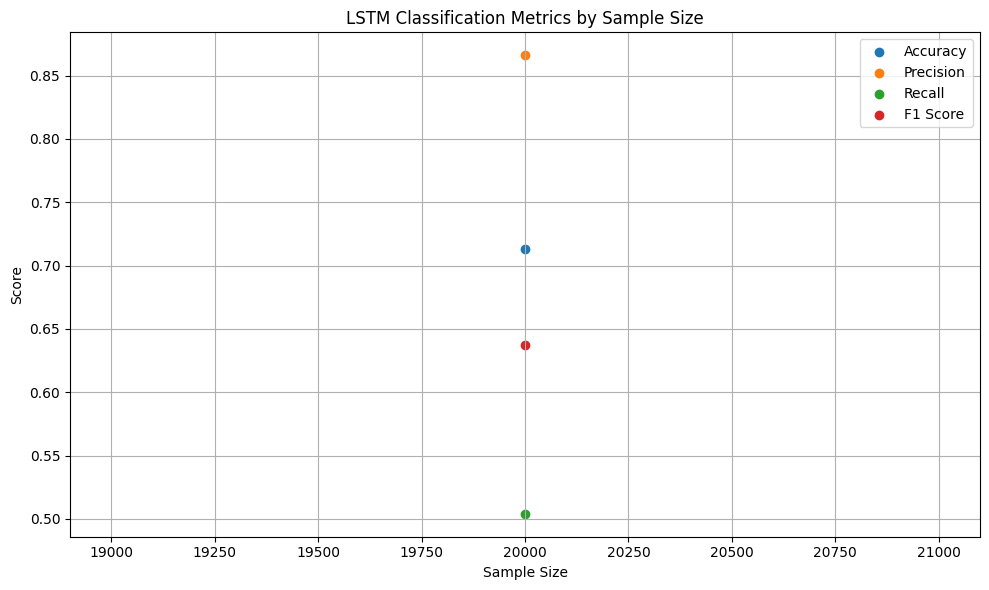

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
0,2025-06-15 15:43:49,LSTM_64_32,veremi_stratified_20000.csv,20000,67.25,25,0.713,0.865979,0.504,0.637168,[[461 39]\n [248 252]],57.7,1696.01,0.285378,0.001364


In [17]:
save_and_visualize_results(results_df)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6144 - loss: 0.6211
Epoch 1: val_loss improved from inf to 0.56357, saving model to 40000_mcp_2025-06-15_15-43-50.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6144 - loss: 0.6211 - val_accuracy: 0.6835 - val_loss: 0.5636
Epoch 2/50
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6926 - loss: 0.5534
Epoch 2: val_loss improved from 0.56357 to 0.54883, saving model to 40000_mcp_2025-06-15_15-43-50.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6926 - loss: 0.5535 - val_accuracy: 0.6870 - val_loss: 0.5488
Epoch 3/50
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6940 - loss: 0.5485
Epoch 3: val_loss improved from 0.54883 to 0.54677, saving model to 40000_mcp_2025-06-15_15-43-50.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6940 - loss: 0.5485 - val_accuracy: 0.6970 - val_loss: 0.5468
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6936 - loss: 0.

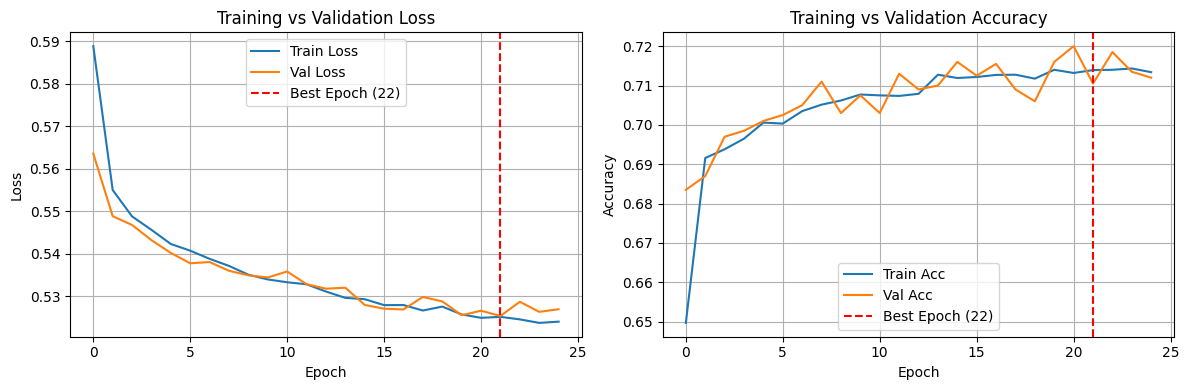

Early stopping triggered. Best epoch: 22, patience used: 3
Best model saved to: 40000_mcp_2025-06-15_15-43-50.keras
Results saved to lstm_test_results.csv


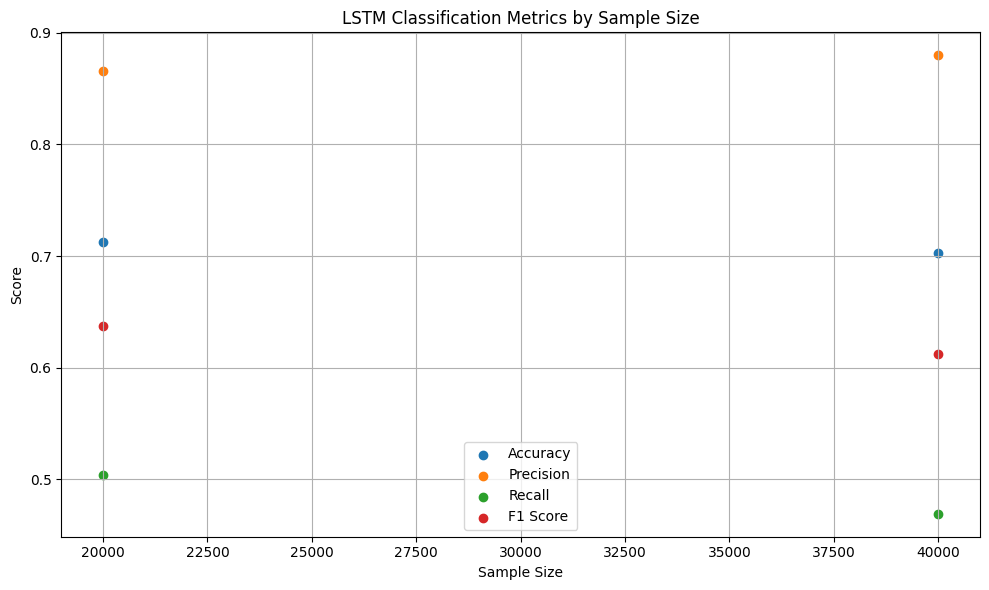

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
1,2025-06-15 15:45:18,LSTM_64_32,veremi_stratified_20000.csv,40000,86.12,22,0.7025,0.879925,0.469,0.611872,[[936 64]\n [531 469]],2.5,1754.84,0.285388,0.000289


In [18]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_40000.csv')
results_df = train_and_evaluate_lstm("LSTM_64_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6403 - loss: 0.6030
Epoch 1: val_loss improved from inf to 0.55011, saving model to 80000_mcp_2025-06-15_15-45-19.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6403 - loss: 0.6030 - val_accuracy: 0.6902 - val_loss: 0.5501
Epoch 2/50
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6994 - loss: 0.5474
Epoch 2: val_loss improved from 0.55011 to 0.54548, saving model to 80000_mcp_2025-06-15_15-45-19.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6994 - loss: 0.5474 - val_accuracy: 0.6955 - val_loss: 0.5455
Epoch 3/50
1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7005 - loss: 0.5457
Epoch 3: val_loss improved from 0.54548 to 0.53974, saving model to 80000_mcp_2025-06-15_15-45-19.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7005 - loss: 0.5457 - val_accuracy: 0.6982 - val_loss: 0.5397
Epoch 4/50
1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.70

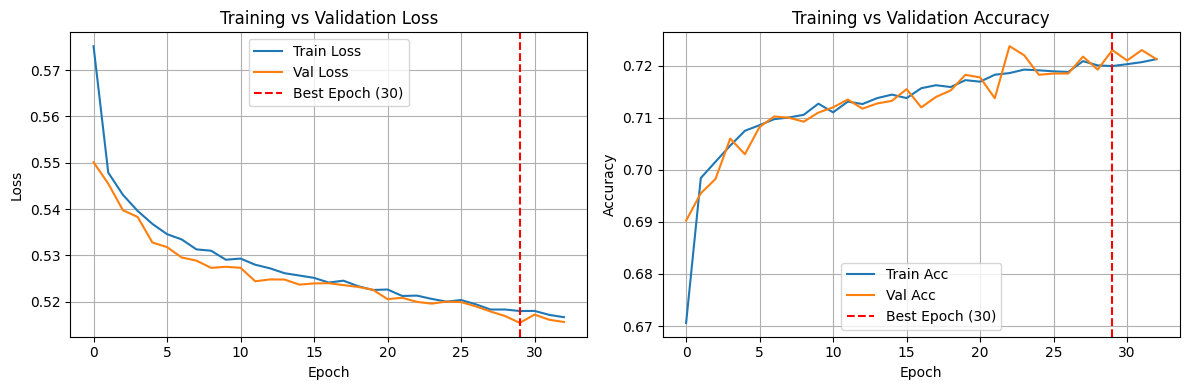

Early stopping triggered. Best epoch: 30, patience used: 3
Best model saved to: 80000_mcp_2025-06-15_15-45-19.keras
Results saved to lstm_test_results.csv


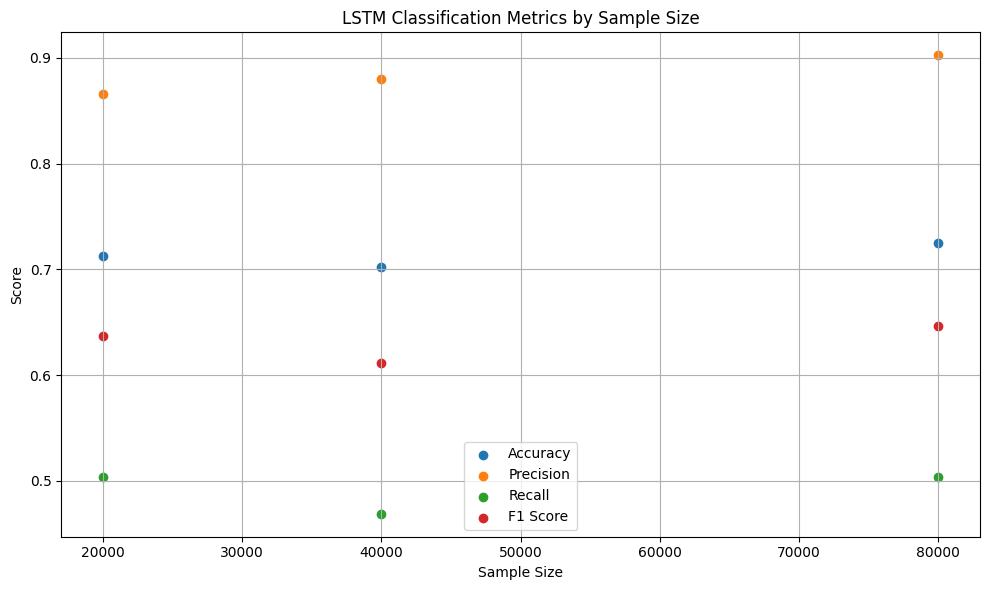

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
2,2025-06-15 15:48:49,LSTM_64_32,veremi_stratified_20000.csv,80000,207.69,30,0.7245,0.90233,0.5035,0.646341,[[1891 109]\n [ 993 1007]],65.7,1728.22,0.285388,0.000133


In [19]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_80000.csv')
results_df = train_and_evaluate_lstm("LSTM_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1680/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6504 - loss: 0.5890
Epoch 1: val_loss improved from inf to 0.53981, saving model to 120000_mcp_2025-06-15_15-48-50.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6506 - loss: 0.5889 - val_accuracy: 0.7017 - val_loss: 0.5398
Epoch 2/50
1681/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7012 - loss: 0.5437
Epoch 2: val_loss improved from 0.53981 to 0.53449, saving model to 120000_mcp_2025-06-15_15-48-50.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7012 - loss: 0.5437 - val_accuracy: 0.7052 - val_loss: 0.5345
Epoch 3/50
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7045 - loss: 0.5380
Epoch 3: val_loss improved from 0.53449 to 0.53070, saving model to 120000_mcp_2025-06-15_15-48-50.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7045 - loss: 0.5380 - val_accuracy: 0.7083 - val_loss: 0.5307
Epoch 4/50
1676/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0

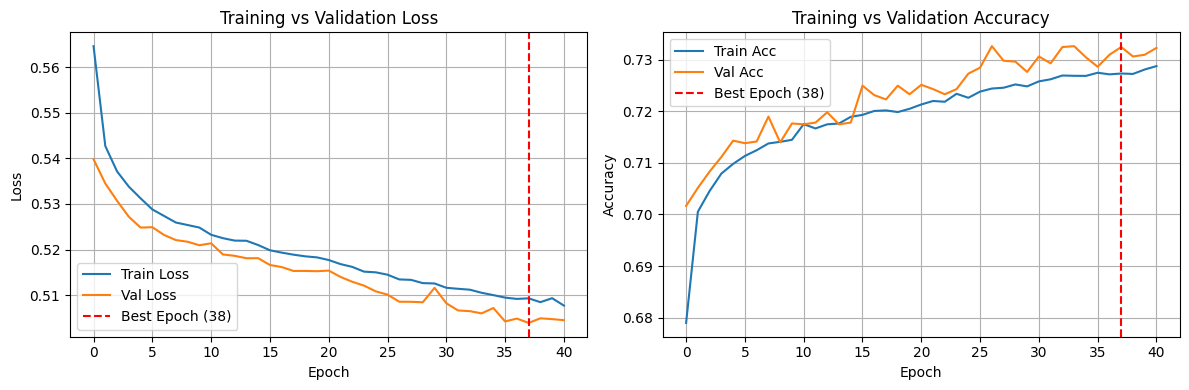

Early stopping triggered. Best epoch: 38, patience used: 3
Best model saved to: 120000_mcp_2025-06-15_15-48-50.keras
Results saved to lstm_test_results.csv


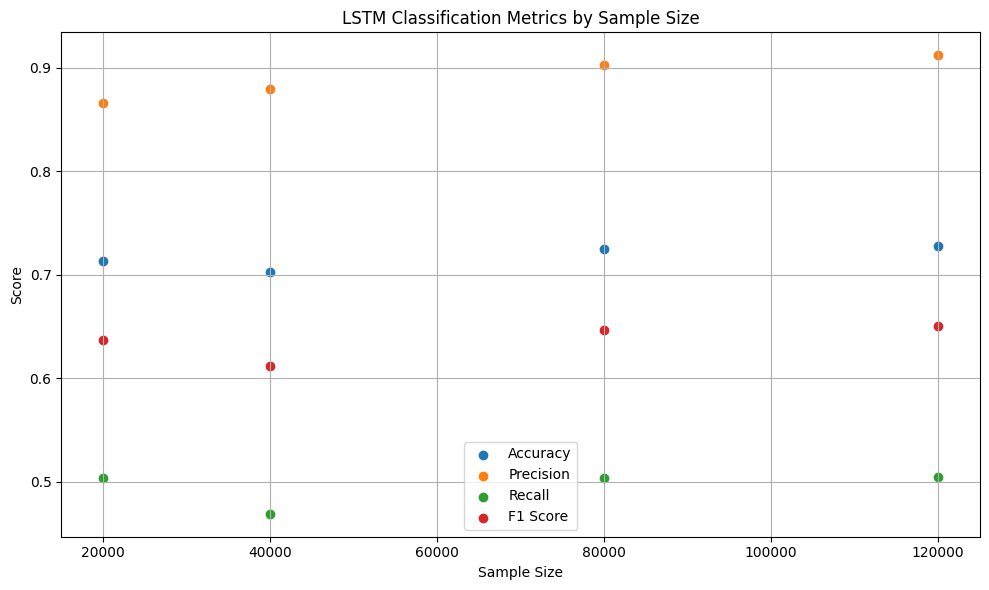

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
3,2025-06-15 15:55:06,LSTM_64_32,veremi_stratified_120000.csv,120000,373.81,38,0.728167,0.912101,0.505,0.650075,[[2854 146]\n [1485 1515]],4.0,1793.55,0.285388,0.000146


In [20]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_120000.csv')
results_df = train_and_evaluate_lstm("LSTM_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2245/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6574 - loss: 0.5836
Epoch 1: val_loss improved from inf to 0.54504, saving model to 160000_mcp_2025-06-15_15-55-08.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.6575 - loss: 0.5835 - val_accuracy: 0.6965 - val_loss: 0.5450
Epoch 2/50
2248/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7003 - loss: 0.5421
Epoch 2: val_loss improved from 0.54504 to 0.53544, saving model to 160000_mcp_2025-06-15_15-55-08.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7003 - loss: 0.5420 - val_accuracy: 0.7017 - val_loss: 0.5354
Epoch 3/50
2248/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7078 - loss: 0.5340
Epoch 3: val_loss improved from 0.53544 to 0.53122, saving model to 160000_mcp_2025-06-15_15-55-08.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7078 - loss: 0.5340 - val_accuracy: 0.7107 - val_loss: 0.5312
Epoch 4/50
2238/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

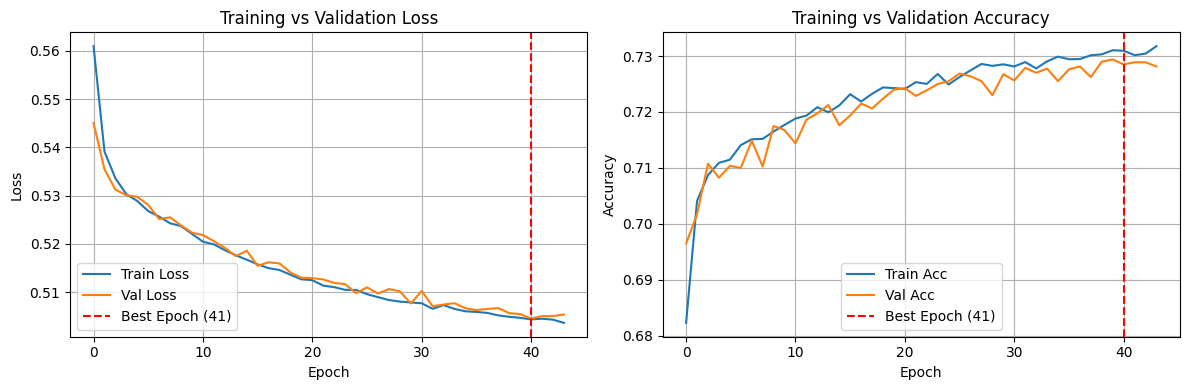

Early stopping triggered. Best epoch: 41, patience used: 3
Best model saved to: 160000_mcp_2025-06-15_15-55-08.keras
Results saved to lstm_test_results.csv


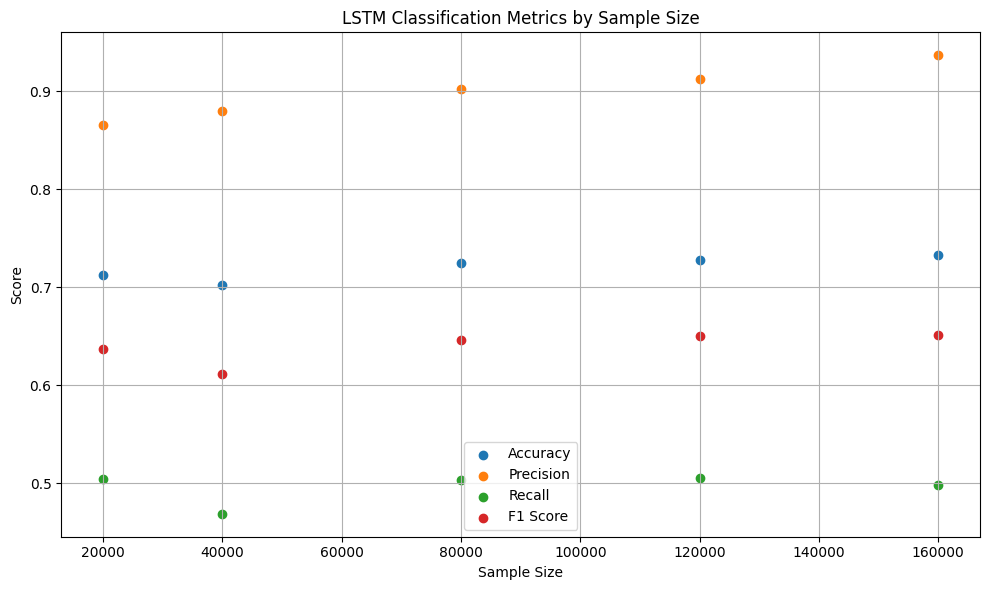

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
4,2025-06-15 16:04:46,LSTM_64_32,veremi_stratified_160000.csv,160000,576.17,41,0.7325,0.93662,0.49875,0.650897,[[3865 135]\n [2005 1995]],2.5,1782.0,0.285388,0.000105


In [21]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_160000.csv')
results_df = train_and_evaluate_lstm("LSTM_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2803/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6623 - loss: 0.5781
Epoch 1: val_loss improved from inf to 0.54117, saving model to 200000_mcp_2025-06-15_16-04-48.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6624 - loss: 0.5780 - val_accuracy: 0.6994 - val_loss: 0.5412
Epoch 2/50
2803/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7038 - loss: 0.5398
Epoch 2: val_loss improved from 0.54117 to 0.53490, saving model to 200000_mcp_2025-06-15_16-04-48.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7038 - loss: 0.5398 - val_accuracy: 0.7088 - val_loss: 0.5349
Epoch 3/50
2802/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7071 - loss: 0.5346
Epoch 3: val_loss improved from 0.53490 to 0.53147, saving model to 200000_mcp_2025-06-15_16-04-48.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7071 - loss: 0.5346 - val_accuracy: 0.7098 - val_loss: 0.5315
Epoch 4/50
2810/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy:

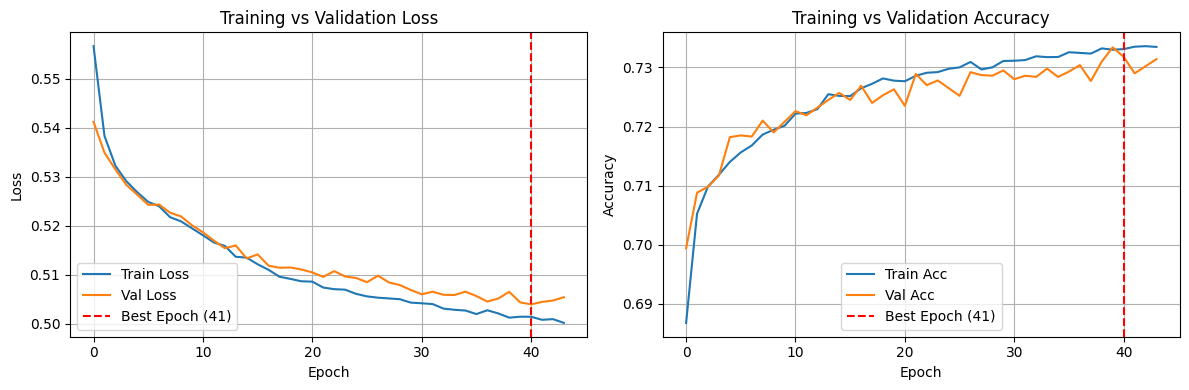

Early stopping triggered. Best epoch: 41, patience used: 3
Best model saved to: 200000_mcp_2025-06-15_16-04-48.keras
Results saved to lstm_test_results.csv


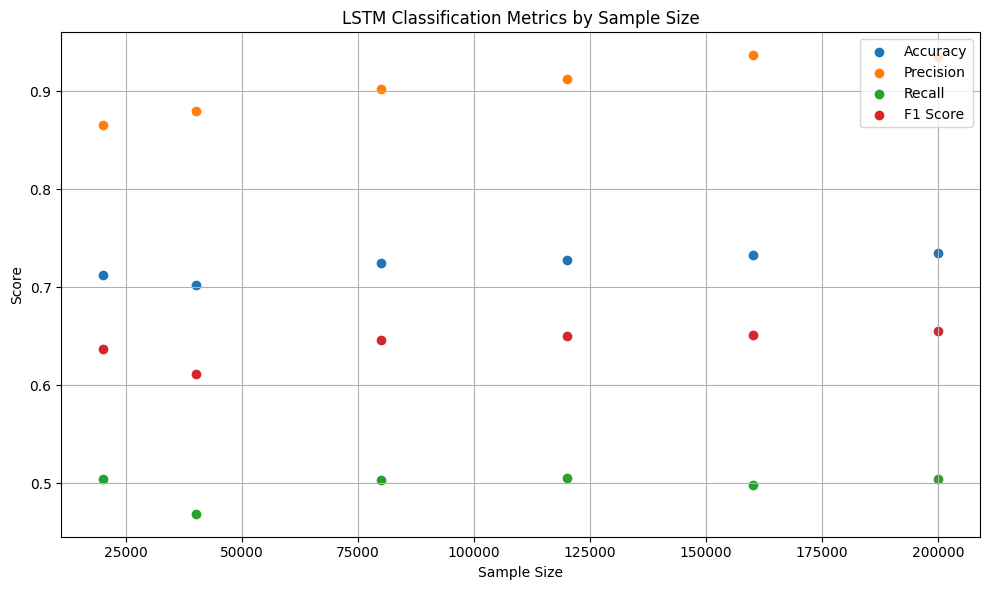

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
5,2025-06-15 16:17:15,LSTM_64_32,veremi_stratified_200000.csv,200000,744.33,41,0.7347,0.935113,0.5044,0.65532,[[4825 175]\n [2478 2522]],3.5,1880.31,0.28539,0.000133


In [22]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_200000.csv')
results_df = train_and_evaluate_lstm("LSTM_64_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000.csv', sample_size, results_df)
save_and_visualize_results(results_df)

In [23]:
def train_and_evaluate_lstm2(xModel,X_train, X_val, X_test, y_train, y_val, y_test, dataset_name, sample_size, results_df):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_path = f'{sample_size}_mcp_{timestamp}.keras'

    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64),
        Dropout(0.3),                     # Helps prevent overfitting
        Dense(128, activation='relu'),   # Expanded representation
        Dense(32, activation='relu'),    # Compressed before output
        Dense(1, activation='sigmoid')   # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Setup callbacks: EarlyStopping + ModelCheckpoint
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

    # Train model
    train_start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    training_time = time.time() - train_start

    # Load best model
    model = load_model(model_path)

    # Predict and evaluate
    infer_start = time.time()
    y_pred_prob = model.predict(X_test).ravel()
    inference_time = (time.time() - infer_start) / len(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    patience_used = len(history.history['val_loss']) - best_epoch

    cpu_usage = psutil.cpu_percent(interval=1)
    memory_usage = psutil.virtual_memory().used / (1024 ** 2)
    model_size = os.path.getsize(model_path) / (1024 * 1024)
    # Log results
    results_df.loc[len(results_df)] = {
        'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Model': xModel,
        'Dataset': dataset_name,
        'Sample Size': sample_size,
        'TrainingTime': round(training_time, 2),
        'Best Epoch': best_epoch,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': str(cm),
        'CPU Usage (%)': cpu_usage,
        'Memory Usage (MB)': round(memory_usage, 2),
        'Model Size (MB)': model_size,
        'Inference Time (s)': round(inference_time, 6)
    }

    # Plot loss and accuracy with vertical line at best epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Early stopping triggered. Best epoch: {best_epoch}, patience used: {patience_used}")
    print(f"Best model saved to: {model_path}")

    return results_df



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,705 (127.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6253 - loss: 0.6286
Epoch 1: val_loss improved from inf to 0.56944, saving model to 20000_mcp_2025-06-15_16-17-16.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6254 - loss: 0.6284 - val_accuracy: 0.6700 - val_loss: 0.5694
Epoch 2/50
271/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6799 - loss: 0.5629
Epoch 2: val_loss improved from 0.56944 to 0.56012, saving model to 20000_mcp_2025-06-15_16-17-16.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6801 - loss: 0.5627 - val_accuracy: 0.6780 - val_loss: 0.5601
Epoch 3/50
278/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6951 - loss: 0.5513
Epoch 3: val_loss improved from 0.56012 to 0.55588, saving model to 20000_mcp_2025-06-15_16-17-16.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6951 - loss: 0.5513 - val_accuracy: 0.6820 - val_loss: 0.5559
Epoch 4/50
277/282 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6974 - loss: 0.54

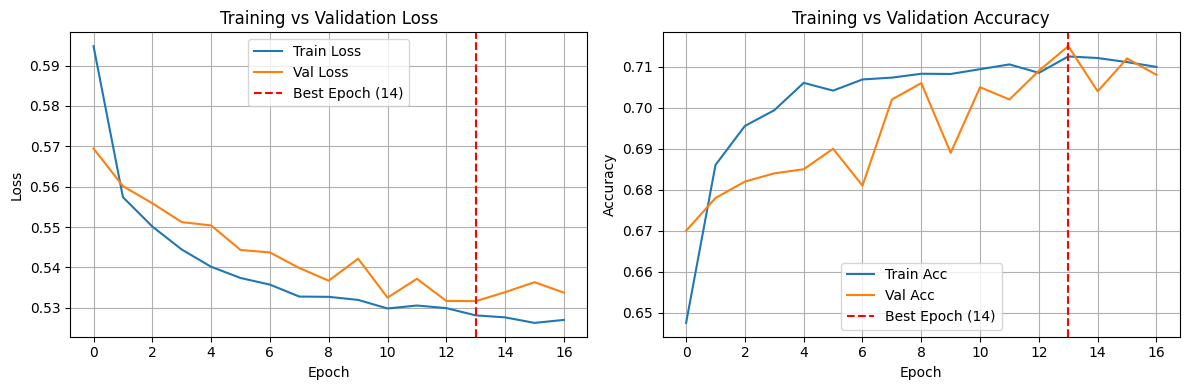

Early stopping triggered. Best epoch: 14, patience used: 3
Best model saved to: 20000_mcp_2025-06-15_16-17-16.keras
Results saved to lstm_test_results.csv


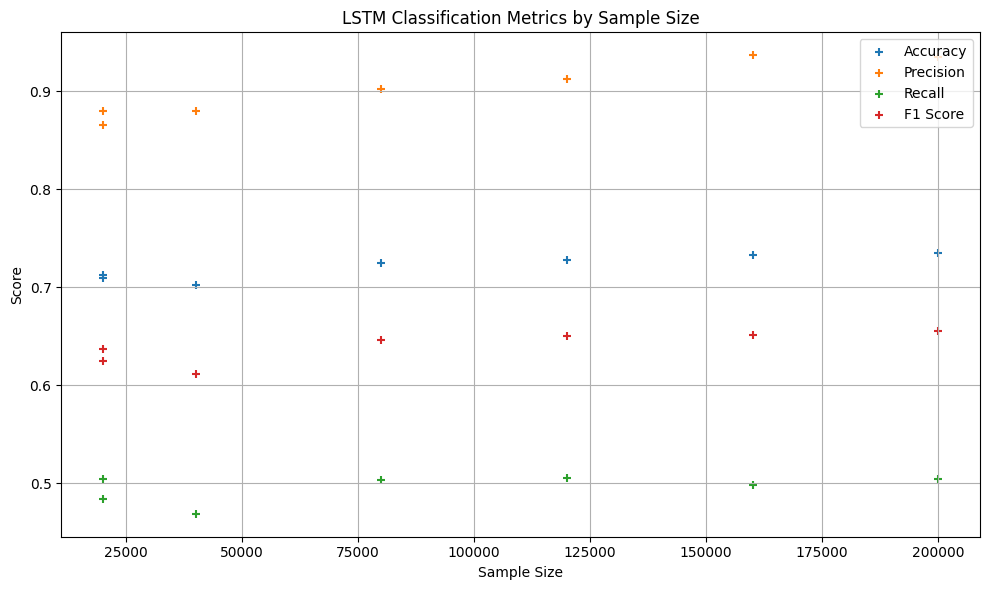

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
6,2025-06-15 16:17:56,LSTM_64_128_32,veremi_stratified_20000_3.csv,20000,NaN,14,0.709,0.88,0.484,0.624516,[[467 33]\n [258 242]],3.0,1856.21,NaN,0.000688


In [24]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_20000.csv')
results_df = train_and_evaluate_lstm2("LSTM_64_128_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000_3.csv', sample_size, results_df)
save_and_visualize_results(results_df, '+')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,705 (127.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
554/563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6369 - loss: 0.6055
Epoch 1: val_loss improved from inf to 0.55715, saving model to 40000_mcp_2025-06-15_16-17-57.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6375 - loss: 0.6050 - val_accuracy: 0.6870 - val_loss: 0.5572
Epoch 2/50
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6988 - loss: 0.5477
Epoch 2: val_loss improved from 0.55715 to 0.54352, saving model to 40000_mcp_2025-06-15_16-17-57.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6988 - loss: 0.5477 - val_accuracy: 0.6990 - val_loss: 0.5435
Epoch 3/50
557/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7001 - loss: 0.5406
Epoch 3: val_loss improved from 0.54352 to 0.53577, saving model to 40000_mcp_2025-06-15_16-17-57.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7001 - loss: 0.5406 - val_accuracy: 0.7005 - val_loss: 0.5358
Epoch 4/50
551/563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7056 - loss: 0.53

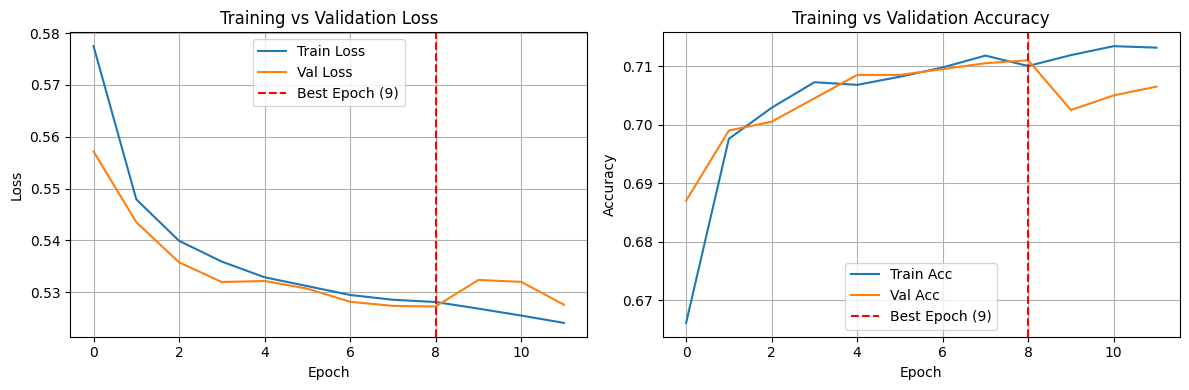

Early stopping triggered. Best epoch: 9, patience used: 3
Best model saved to: 40000_mcp_2025-06-15_16-17-57.keras
Results saved to lstm_test_results.csv


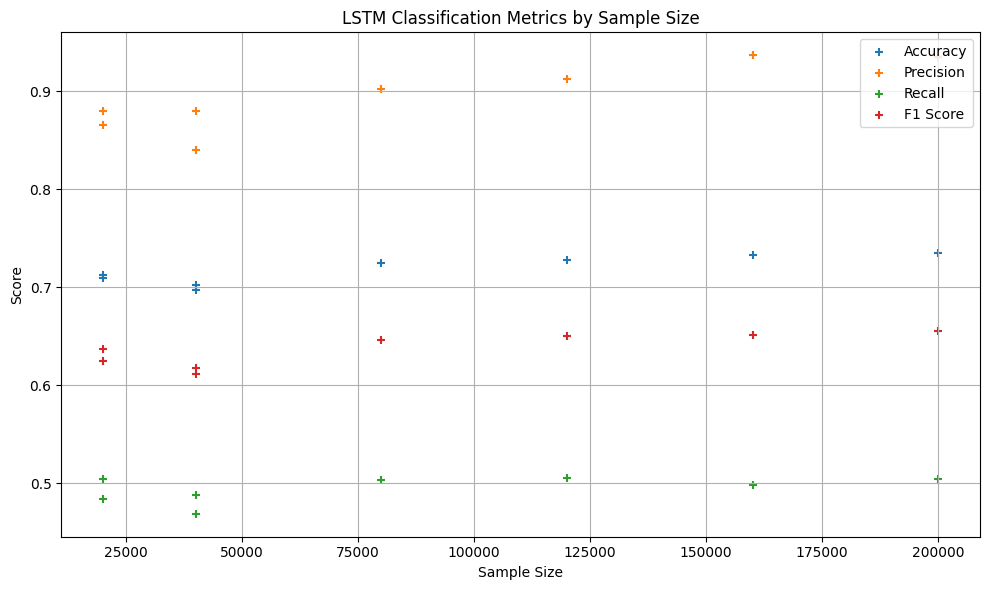

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
7,2025-06-15 16:18:45,LSTM_64_128_32,veremi_stratified_40000_3.csv,40000,NaN,9,0.6975,0.839931,0.488,0.617331,[[907 93]\n [512 488]],2.0,1921.29,NaN,0.000284


In [25]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_40000.csv')
results_df = train_and_evaluate_lstm2("LSTM_64_128_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_40000_3.csv', sample_size, results_df)
save_and_visualize_results(results_df, '+')

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,705 (127.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6614 - loss: 0.5838
Epoch 1: val_loss improved from inf to 0.54690, saving model to 80000_mcp_2025-06-15_16-18-47.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6614 - loss: 0.5838 - val_accuracy: 0.6942 - val_loss: 0.5469
Epoch 2/50
1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7053 - loss: 0.5390
Epoch 2: val_loss improved from 0.54690 to 0.53679, saving model to 80000_mcp_2025-06-15_16-18-47.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7053 - loss: 0.5390 - val_accuracy: 0.6963 - val_loss: 0.5368
Epoch 3/50
1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7088 - loss: 0.5311
Epoch 3: val_loss improved from 0.53679 to 0.53294, saving model to 80000_mcp_2025-06-15_16-18-47.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7088 - loss: 0.5311 - val_accuracy: 0.7063 - val_loss: 0.5329
Epoch 4/50
1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.712

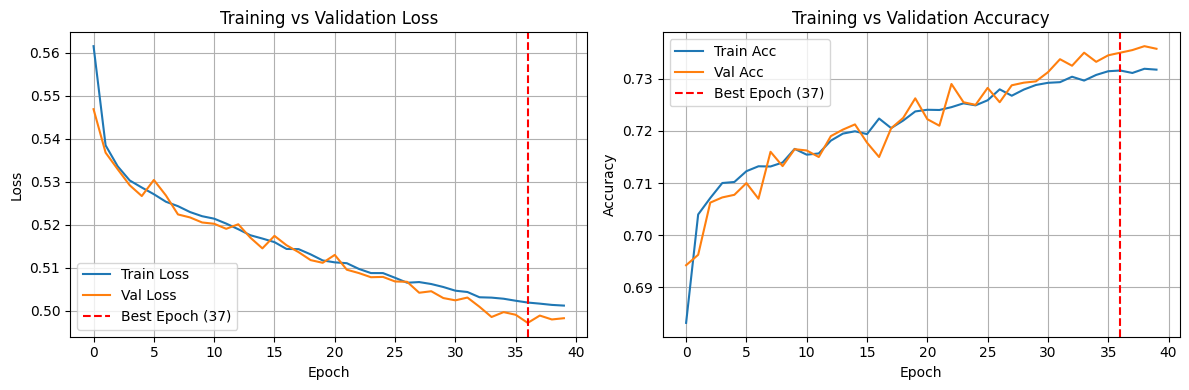

Early stopping triggered. Best epoch: 37, patience used: 3
Best model saved to: 80000_mcp_2025-06-15_16-18-47.keras
Results saved to lstm_test_results.csv


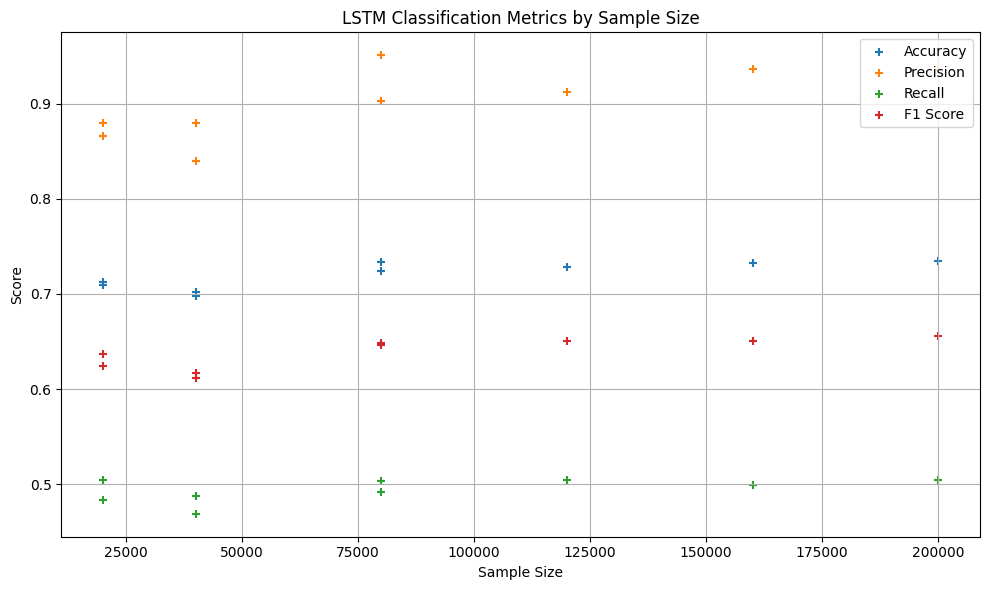

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
8,2025-06-15 16:23:18,LSTM_64_128_32,veremi_stratified_80000_3.csv,80000,NaN,37,0.73325,0.950725,0.492,0.648435,[[1949 51]\n [1016 984]],3.0,1921.06,NaN,0.00013


In [26]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_80000.csv')
results_df = train_and_evaluate_lstm2("LSTM_64_128_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_80000_3.csv', sample_size, results_df)
save_and_visualize_results(results_df , '+')

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,705 (127.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2245/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6705 - loss: 0.5724
Epoch 1: val_loss improved from inf to 0.53562, saving model to 160000_mcp_2025-06-15_16-23-20.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6706 - loss: 0.5724 - val_accuracy: 0.7003 - val_loss: 0.5356
Epoch 2/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7094 - loss: 0.5326
Epoch 2: val_loss improved from 0.53562 to 0.53323, saving model to 160000_mcp_2025-06-15_16-23-20.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7094 - loss: 0.5326 - val_accuracy: 0.7042 - val_loss: 0.5332
Epoch 3/50
2242/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7124 - loss: 0.5276
Epoch 3: val_loss improved from 0.53323 to 0.52955, saving model to 160000_mcp_2025-06-15_16-23-20.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7124 - loss: 0.5276 - val_accuracy: 0.7090 - val_loss: 0.5296
Epoch 4/50
2244/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

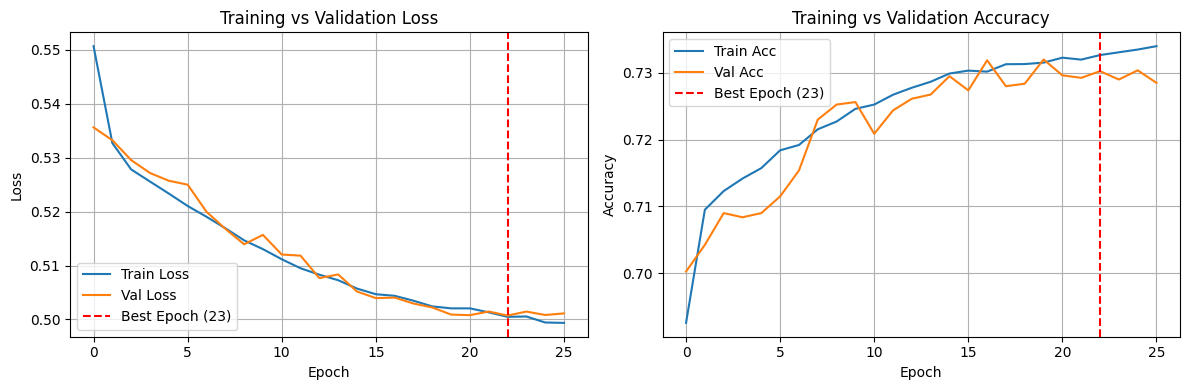

Early stopping triggered. Best epoch: 23, patience used: 3
Best model saved to: 160000_mcp_2025-06-15_16-23-20.keras
Results saved to lstm_test_results.csv


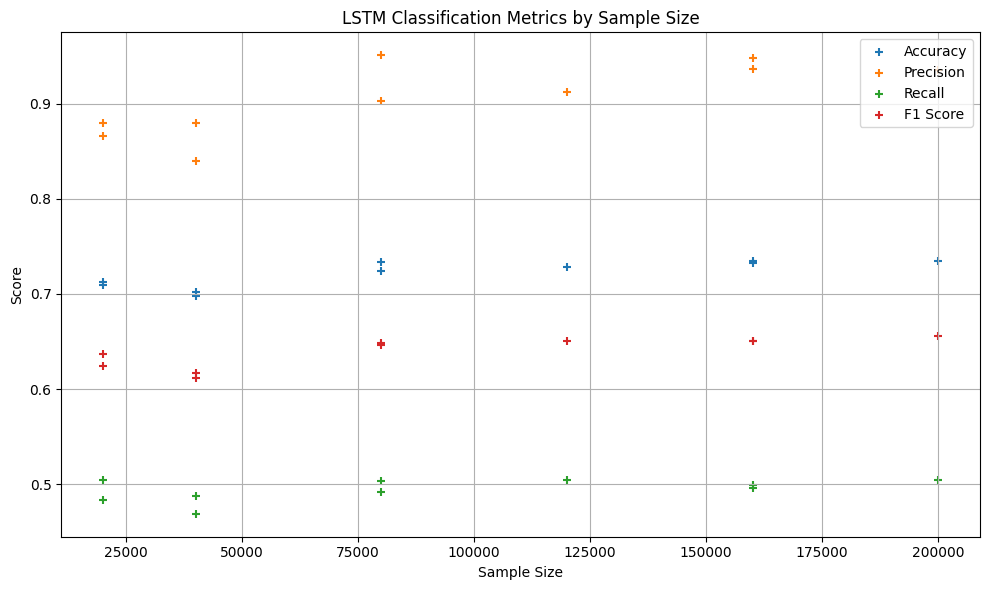

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
9,2025-06-15 16:28:59,LSTM_64_128_32,veremi_stratified_160000_3.csv,160000,NaN,23,0.734125,0.947444,0.49575,0.650911,[[3890 110]\n [2017 1983]],2.0,1956.34,NaN,0.000168


In [27]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_160000.csv')
results_df = train_and_evaluate_lstm2("LSTM_64_128_32", X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000_3.csv', sample_size, results_df)
save_and_visualize_results(results_df , '+')

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,705 (127.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2804/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6740 - loss: 0.5676
Epoch 1: val_loss improved from inf to 0.53228, saving model to 200000_mcp_2025-06-15_16-29-01.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6741 - loss: 0.5675 - val_accuracy: 0.7062 - val_loss: 0.5323
Epoch 2/50
2808/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7111 - loss: 0.5307
Epoch 2: val_loss improved from 0.53228 to 0.52682, saving model to 200000_mcp_2025-06-15_16-29-01.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7111 - loss: 0.5307 - val_accuracy: 0.7129 - val_loss: 0.5268
Epoch 3/50
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7116 - loss: 0.5278
Epoch 3: val_loss improved from 0.52682 to 0.52394, saving model to 200000_mcp_2025-06-15_16-29-01.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7116 - loss: 0.5278 - val_accuracy: 0.7156 - val_loss: 0.5239
Epoch 4/50
2811/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy:

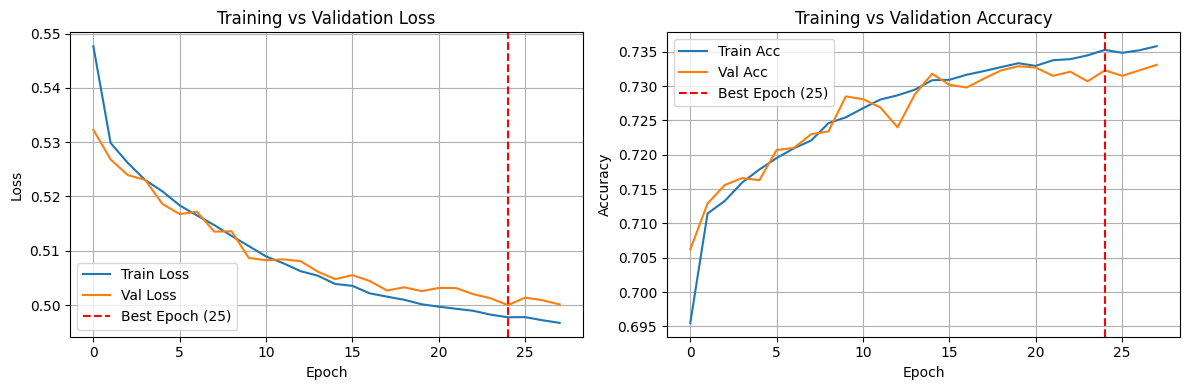

Early stopping triggered. Best epoch: 25, patience used: 3
Best model saved to: 200000_mcp_2025-06-15_16-29-01.keras
Results saved to lstm_test_results.csv


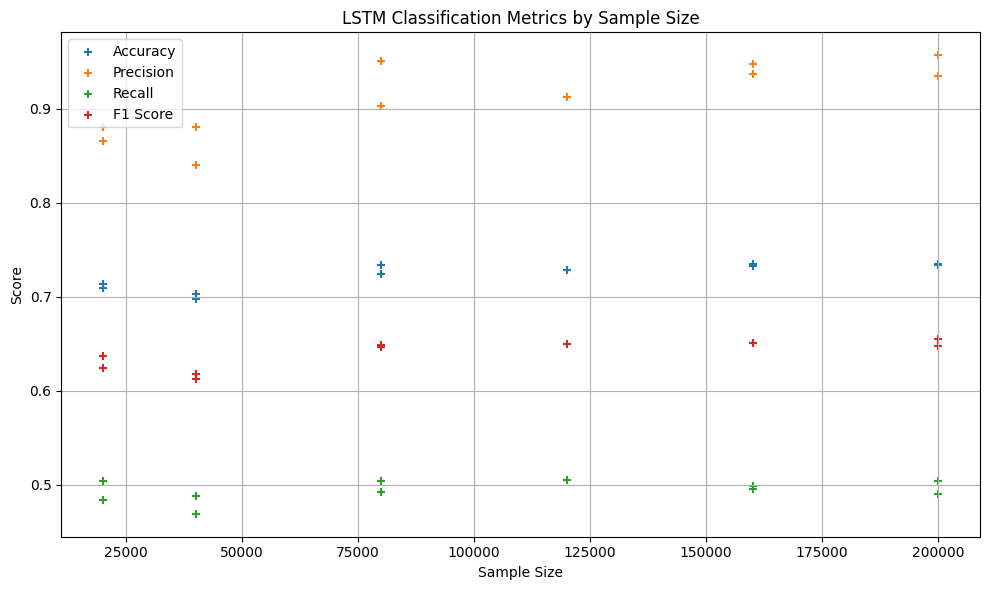

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
10,2025-06-15 16:36:43,LSTM_64_128_32,veremi_stratified_200000_3.csv,200000,NaN,25,0.7338,0.956641,0.4898,0.647884,[[4889 111]\n [2551 2449]],56.3,2048.9,NaN,0.000135


In [28]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_200000.csv')
results_df = train_and_evaluate_lstm2("LSTM_64_128_32",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000_3.csv', sample_size, results_df)
save_and_visualize_results(results_df , '+')

In [29]:
def train_and_evaluate_lstm3(xModel,X_train, X_val, X_test, y_train, y_val, y_test, dataset_name, sample_size, results_df):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    model_path = f'{sample_size}_mcp_{timestamp}.keras'

    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(64, return_sequences=True),     # First LSTM layer (preserves sequence)
        Dropout(0.3),
        LSTM(32),                            # Second LSTM layer (final output)
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # Setup callbacks: EarlyStopping + ModelCheckpoint
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

    # Train model
    train_start = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=1
    )
    training_time = time.time() - train_start

    # Load best model
    model = load_model(model_path)

    # Predict and evaluate
    infer_start = time.time()
    y_pred_prob = model.predict(X_test).ravel()
    inference_time = (time.time() - infer_start) / len(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    patience_used = len(history.history['val_loss']) - best_epoch

    cpu_usage = psutil.cpu_percent(interval=1)
    memory_usage = psutil.virtual_memory().used / (1024 ** 2)

    # Log results
    results_df.loc[len(results_df)] = {
        'Timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Model': xModel,
        'Dataset': dataset_name,
        'Sample Size': sample_size,
        'TrainingTime': round(training_time, 2),
        'Best Epoch': best_epoch,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': str(cm),
        'CPU Usage (%)': cpu_usage,
        'Memory Usage (MB)': round(memory_usage, 2),
        'Inference Time (s)': round(inference_time, 6)
    }

    # Plot loss and accuracy with vertical line at best epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.axvline(x=best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Early stopping triggered. Best epoch: {best_epoch}, patience used: {patience_used}")
    print(f"Best model saved to: {model_path}")

    return results_df



Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 1, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,817 (136.00 KB)

 Trainable params: 34,817 (136.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
280/282 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5884 - loss: 0.6436
Epoch 1: val_loss improved from inf to 0.57809, saving model to 20000_mcp_2025-06-15_16-36-44.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5888 - loss: 0.6432 - val_accuracy: 0.6540 - val_loss: 0.5781
Epoch 2/50
276/282 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6692 - loss: 0.5710
Epoch 2: val_loss improved from 0.57809 to 0.56541, saving model to 20000_mcp_2025-06-15_16-36-44.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6693 - loss: 0.5710 - val_accuracy: 0.6740 - val_loss: 0.5654
Epoch 3/50
273/282 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6825 - loss: 0.5626
Epoch 3: val_loss improved from 0.56541 to 0.56161, saving model to 20000_mcp_2025-06-15_16-36-44.keras
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6825 - loss: 0.5624 - val_accuracy: 0.6770 - val_loss: 0.5616
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6858 - loss: 0.55

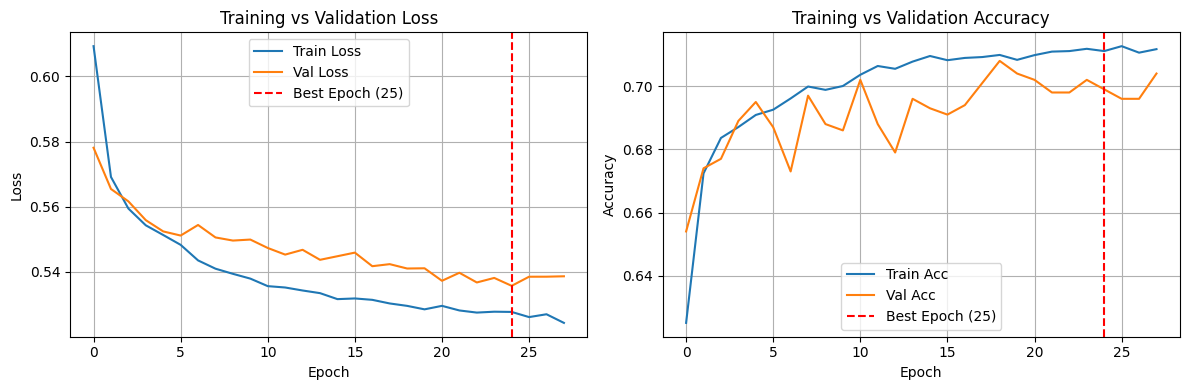

Early stopping triggered. Best epoch: 25, patience used: 3
Best model saved to: 20000_mcp_2025-06-15_16-36-44.keras
Results saved to lstm_test_results.csv


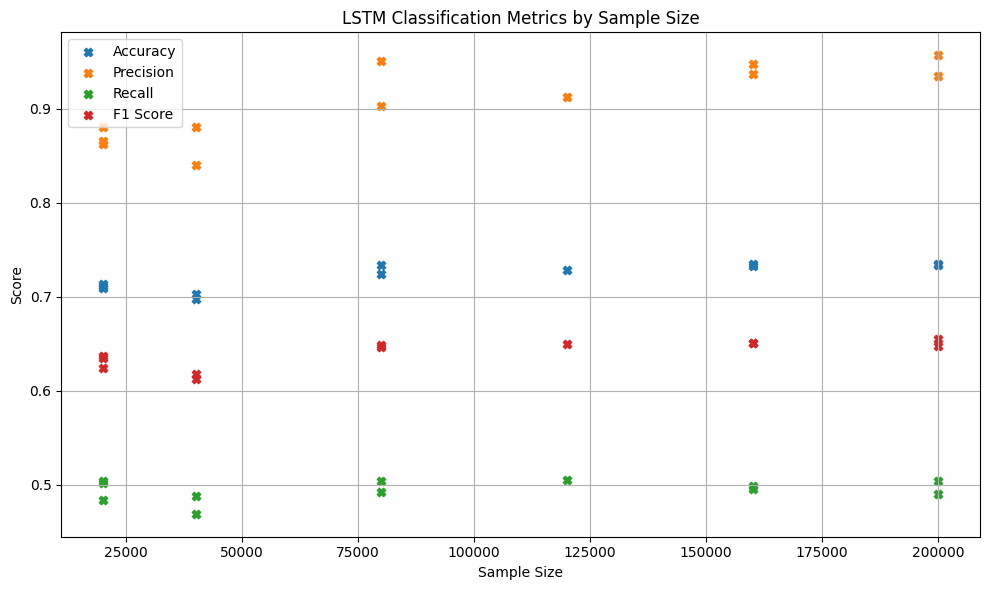

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
11,2025-06-15 16:37:51,LSTM_64_32_64,veremi_stratified_20000_4.csv,20000,NaN,25,0.711,0.862543,0.502,0.63464,[[460 40]\n [249 251]],5.1,2052.49,NaN,0.001718


In [30]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_20000.csv')
results_df = train_and_evaluate_lstm3("LSTM_64_32_64",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_20000_4.csv', sample_size, results_df)
save_and_visualize_results(results_df , 'X')

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 1, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,817 (136.00 KB)

 Trainable params: 34,817 (136.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
557/563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6236 - loss: 0.6171
Epoch 1: val_loss improved from inf to 0.56393, saving model to 40000_mcp_2025-06-15_16-37-52.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6239 - loss: 0.6167 - val_accuracy: 0.6870 - val_loss: 0.5639
Epoch 2/50
561/563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6867 - loss: 0.5602
Epoch 2: val_loss improved from 0.56393 to 0.54985, saving model to 40000_mcp_2025-06-15_16-37-52.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6867 - loss: 0.5602 - val_accuracy: 0.6945 - val_loss: 0.5498
Epoch 3/50
562/563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6928 - loss: 0.5487
Epoch 3: val_loss improved from 0.54985 to 0.54511, saving model to 40000_mcp_2025-06-15_16-37-52.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6928 - loss: 0.5487 - val_accuracy: 0.6970 - val_loss: 0.5451
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6975 - loss: 0.54

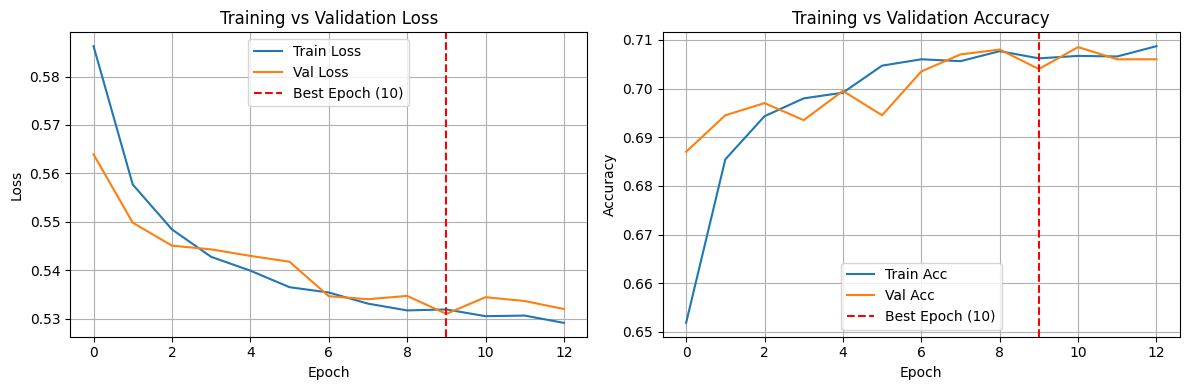

Early stopping triggered. Best epoch: 10, patience used: 3
Best model saved to: 40000_mcp_2025-06-15_16-37-52.keras
Results saved to lstm_test_results.csv


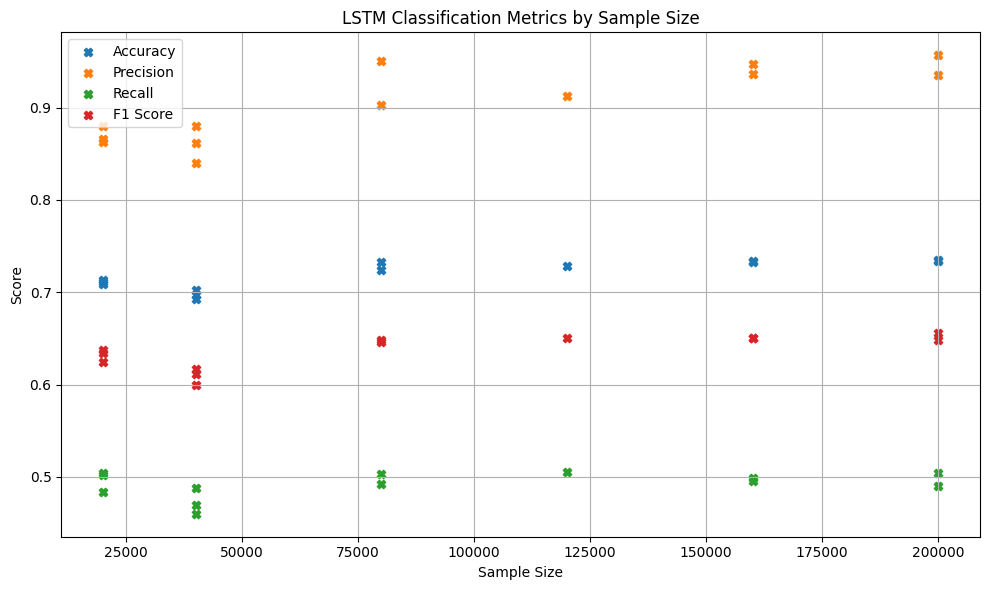

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
12,2025-06-15 16:38:58,LSTM_64_32_64,veremi_stratified_40000_4.csv,40000,NaN,10,0.693,0.861423,0.46,0.599739,[[926 74]\n [540 460]],2.5,2103.43,NaN,0.000457


In [31]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_40000.csv')
results_df = train_and_evaluate_lstm3("LSTM_64_32_64",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_40000_4.csv', sample_size, results_df)
save_and_visualize_results(results_df , 'X')

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 1, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,817 (136.00 KB)

 Trainable params: 34,817 (136.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6451 - loss: 0.5986
Epoch 1: val_loss improved from inf to 0.54848, saving model to 80000_mcp_2025-06-15_16-38-59.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6454 - loss: 0.5983 - val_accuracy: 0.6927 - val_loss: 0.5485
Epoch 2/50
1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6911 - loss: 0.5488
Epoch 2: val_loss improved from 0.54848 to 0.54104, saving model to 80000_mcp_2025-06-15_16-38-59.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6911 - loss: 0.5488 - val_accuracy: 0.6940 - val_loss: 0.5410
Epoch 3/50
1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7002 - loss: 0.5408
Epoch 3: val_loss improved from 0.54104 to 0.53805, saving model to 80000_mcp_2025-06-15_16-38-59.keras
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7002 - loss: 0.5408 - val_accuracy: 0.6957 - val_loss: 0.5380
Epoch 4/50
1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.70

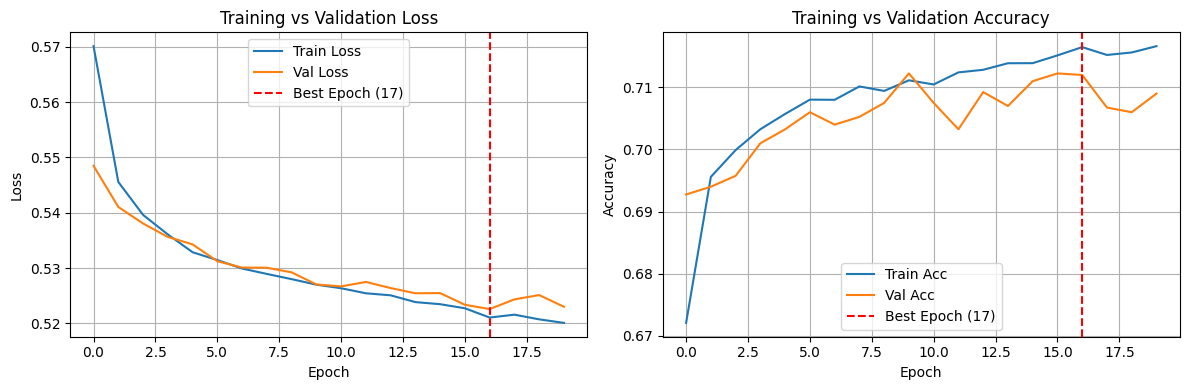

Early stopping triggered. Best epoch: 17, patience used: 3
Best model saved to: 80000_mcp_2025-06-15_16-38-59.keras
Results saved to lstm_test_results.csv


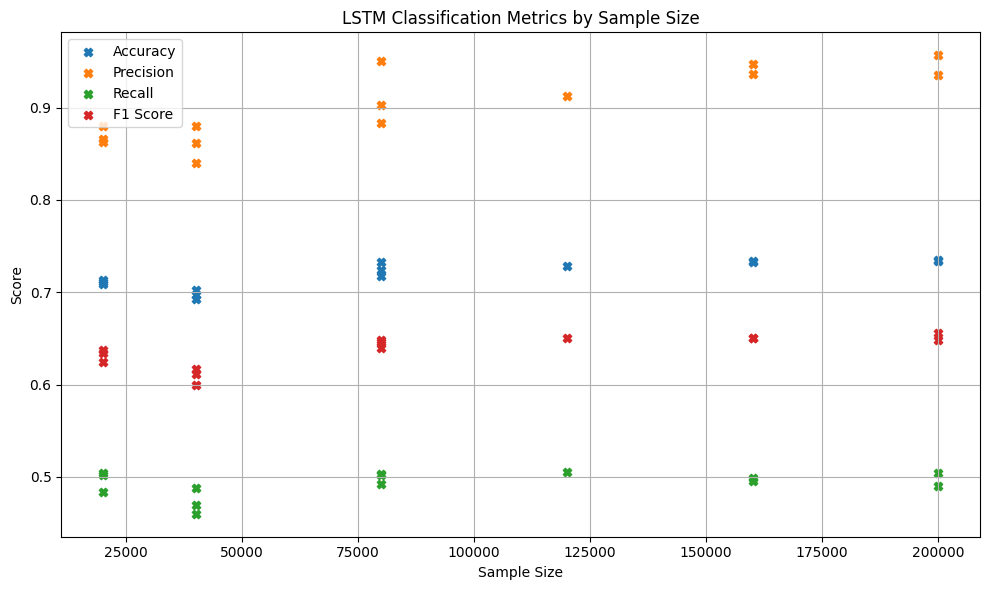

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
13,2025-06-15 16:41:52,LSTM_64_32_64,veremi_stratified_80000_4.csv,80000,NaN,17,0.71775,0.8837,0.5015,0.639872,[[1868 132]\n [ 997 1003]],2.5,2168.33,NaN,0.000172


In [32]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_80000.csv')
results_df = train_and_evaluate_lstm3("LSTM_64_32_64",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_80000_4.csv', sample_size, results_df)
save_and_visualize_results(results_df , 'X')

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 1, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,817 (136.00 KB)

 Trainable params: 34,817 (136.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1685/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6545 - loss: 0.5880
Epoch 1: val_loss improved from inf to 0.53813, saving model to 120000_mcp_2025-06-15_16-41-53.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.6546 - loss: 0.5879 - val_accuracy: 0.7008 - val_loss: 0.5381
Epoch 2/50
1682/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7006 - loss: 0.5409
Epoch 2: val_loss improved from 0.53813 to 0.53157, saving model to 120000_mcp_2025-06-15_16-41-53.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7006 - loss: 0.5409 - val_accuracy: 0.7103 - val_loss: 0.5316
Epoch 3/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7034 - loss: 0.5361
Epoch 3: val_loss improved from 0.53157 to 0.52615, saving model to 120000_mcp_2025-06-15_16-41-53.keras
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7034 - loss: 0.5361 - val_accuracy: 0.7107 - val_loss: 0.5262
Epoch 4/50
1686/1688 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

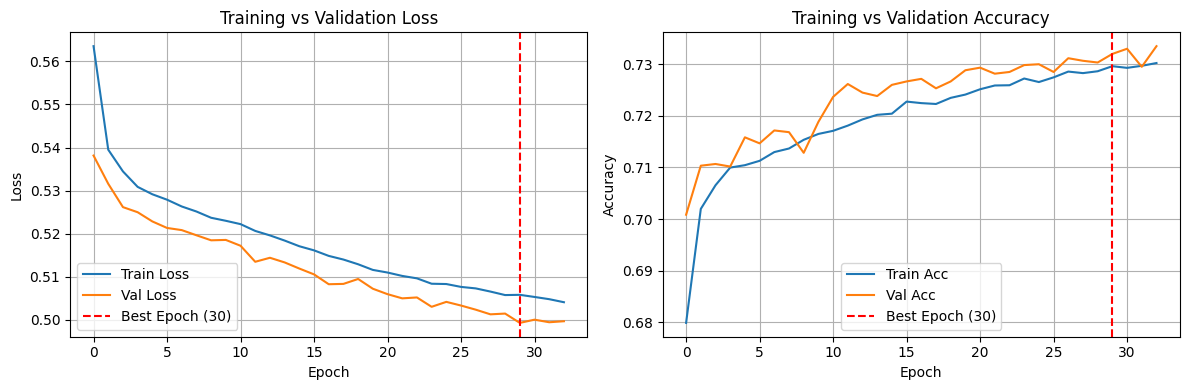

Early stopping triggered. Best epoch: 30, patience used: 3
Best model saved to: 120000_mcp_2025-06-15_16-41-53.keras
Results saved to lstm_test_results.csv


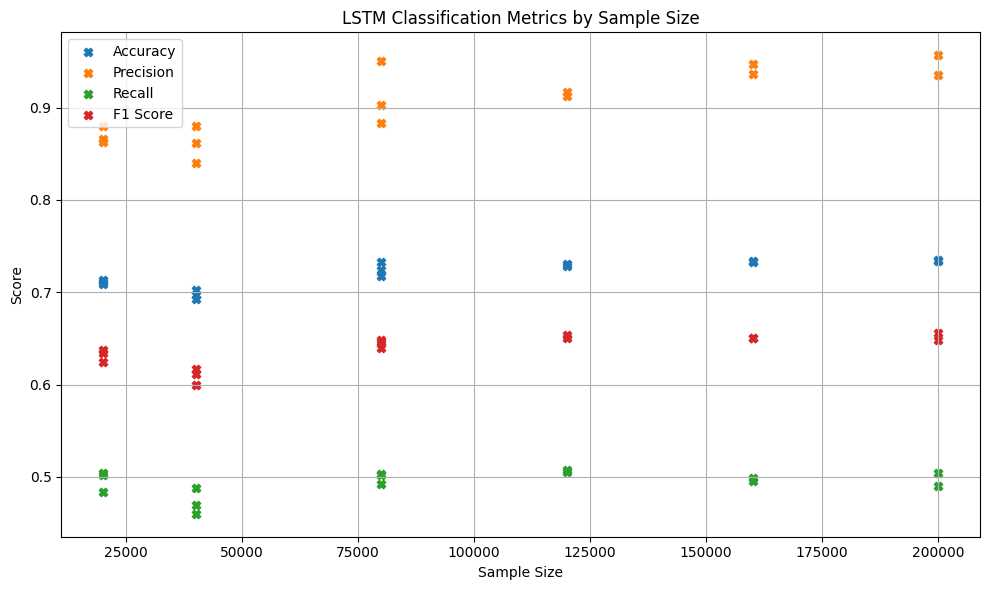

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
14,2025-06-15 16:49:04,LSTM_64_32_64,veremi_stratified_120000_4.csv,120000,NaN,30,0.730667,0.916366,0.507667,0.653368,[[2861 139]\n [1477 1523]],3.0,2209.14,NaN,0.000222


In [33]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_120000.csv')
results_df = train_and_evaluate_lstm3("LSTM_64_32_64",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_120000_4.csv', sample_size, results_df)
save_and_visualize_results(results_df , 'X')

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 1, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,817 (136.00 KB)

 Trainable params: 34,817 (136.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6580 - loss: 0.5813
Epoch 1: val_loss improved from inf to 0.54235, saving model to 160000_mcp_2025-06-15_16-49-06.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.6580 - loss: 0.5813 - val_accuracy: 0.6952 - val_loss: 0.5423
Epoch 2/50
2244/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7010 - loss: 0.5392
Epoch 2: val_loss improved from 0.54235 to 0.53661, saving model to 160000_mcp_2025-06-15_16-49-06.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7010 - loss: 0.5392 - val_accuracy: 0.7001 - val_loss: 0.5366
Epoch 3/50
2244/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7072 - loss: 0.5337
Epoch 3: val_loss improved from 0.53661 to 0.53230, saving model to 160000_mcp_2025-06-15_16-49-06.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.7072 - loss: 0.5337 - val_accuracy: 0.7041 - val_loss: 0.5323
Epoch 4/50
2245/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

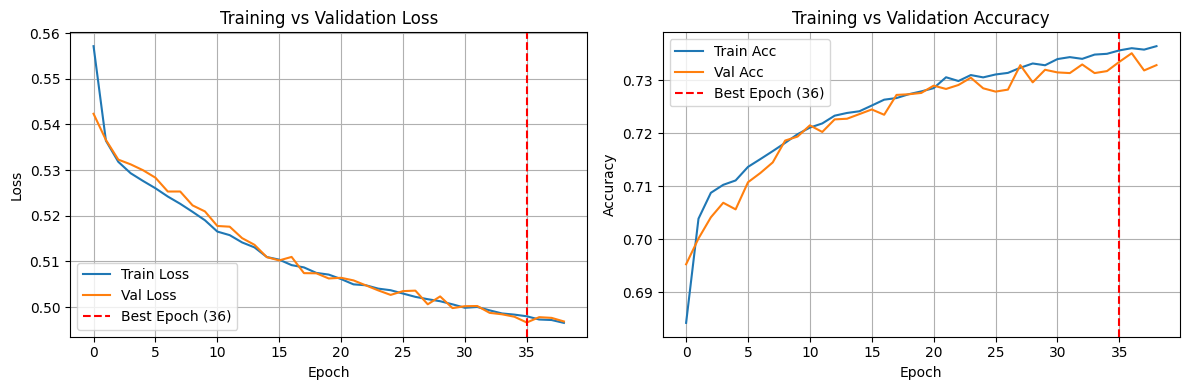

Early stopping triggered. Best epoch: 36, patience used: 3
Best model saved to: 160000_mcp_2025-06-15_16-49-06.keras
Results saved to lstm_test_results.csv


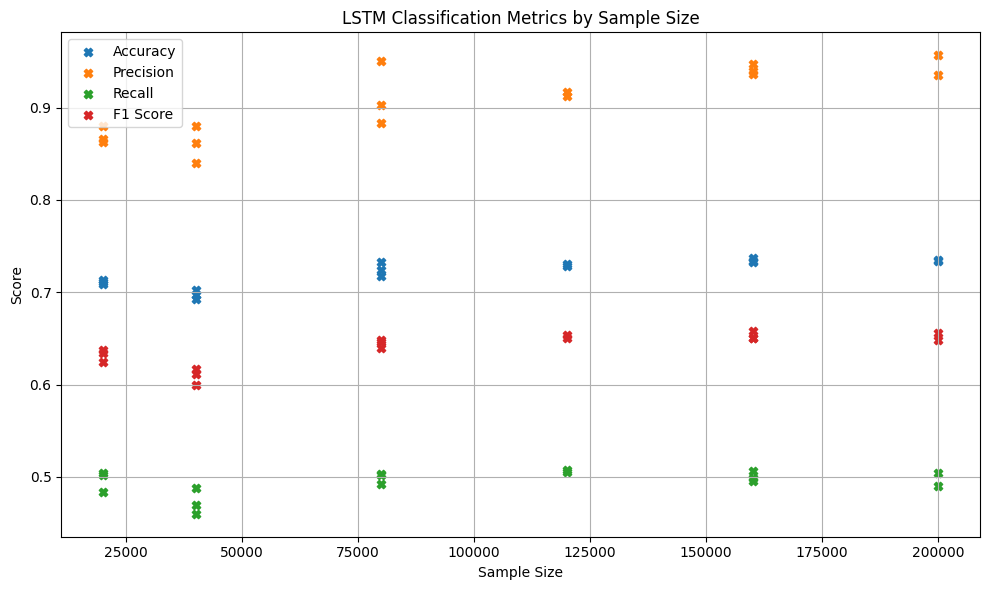

,Timestamp,Model,Dataset,Sample Size,Training Time (s),Best Epoch,Accuracy,Precision,Recall,F1 Score,Confusion Matrix,CPU Usage (%),Memory Usage (MB),Model Size (MB),Inference Time (s)
15,2025-06-15 17:00:08,LSTM_64_32_64,veremi_stratified_160000_4.csv,160000,NaN,36,0.736875,0.940084,0.506,0.65789,[[3871 129]\n [1976 2024]],2.5,2229.52,NaN,0.000131


In [34]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_160000.csv')
results_df = train_and_evaluate_lstm3("LSTM_64_32_64",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_160000_4.csv', sample_size, results_df)
save_and_visualize_results(results_df , 'X')

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, sample_size = prepare_lstm_dataset('/content/veremi_stratified_200000.csv')
results_df = train_and_evaluate_lstm3("LSTM_64_32_64",X_train, X_val, X_test, y_train, y_val, y_test, 'veremi_stratified_200000_4.csv', sample_size, results_df)
save_and_visualize_results(results_df , 'X')

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 1, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,817 (136.00 KB)

 Trainable params: 34,817 (136.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2812/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6663 - loss: 0.5754
Epoch 1: val_loss improved from inf to 0.53880, saving model to 200000_mcp_2025-06-15_17-00-10.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.6663 - loss: 0.5754 - val_accuracy: 0.7010 - val_loss: 0.5388
Epoch 2/50
2810/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7046 - loss: 0.5361
Epoch 2: val_loss improved from 0.53880 to 0.53187, saving model to 200000_mcp_2025-06-15_17-00-10.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.7046 - loss: 0.5361 - val_accuracy: 0.7034 - val_loss: 0.5319
Epoch 3/50
2808/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7095 - loss: 0.5294
Epoch 3: val_loss improved from 0.53187 to 0.52739, saving model to 200000_mcp_2025-06-15_17-00-10.keras
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.7095 - loss: 0.5294 - val_accuracy: 0.7104 - val_loss: 0.5274
Epoch 4/50
2808/2813 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

In [ ]:
from google.colab import files
files.download("/content/lstm_test_results.csv")

In [ ]:
from datetime import datetime

# Get current date and time
now = datetime.now()

# Print formatted datetime
print("Current date and time:", now.strftime("%Y-%m-%d %H:%M:%S"))